<a href="https://colab.research.google.com/github/JARACH-209/Software_Engineering_Project/blob/master/HF_Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN
import pickle
plt.style.use("seaborn")
# Function to run 10 fold cross validation

def cross_validation(clf,X,Y):
    cv_rf = cross_validate(clf,X,Y,scoring=('accuracy','roc_auc','recall','precision'),cv = 10,n_jobs=-1)
    print("Average CV Accuracy Test \t%0.2f"%(cv_rf['test_accuracy'].mean()*100))
    print("Average CV ROC-AUC Score \t%0.2f"%(cv_rf['test_roc_auc'].mean()*100))
    print("Average CV Recall Score \t%0.2f"%(cv_rf['test_recall'].mean()*100))
    print("Average CV Precision Score \t%0.2f"%(cv_rf['test_precision'].mean()*100))
    print("-----------------------------")
    print("Best Accuracy CV : \t\t%0.2f"%max(cv_rf['test_accuracy']*100))
    print("Best ROC CV : \t\t\t%0.2f"%max(cv_rf['test_roc_auc']*100))
    print("Best Recall CV : \t\t%0.2f"%max(cv_rf['test_recall']*100))
    print("Best Precision CV : \t\t%0.2f"%max(cv_rf['test_precision']*100))

def scaling_X(X_fit,X_transform):
    sscaler = preprocessing.StandardScaler().fit(X_fit)
    X = sscaler.transform(X_transform)
    return X

In [ ]:
df_red = pd.read_csv("/content/HF_Classification_Reduced_Features.csv")

#clipping the outliers
df_red.drop(columns=['Unnamed: 0','Killip.grade'],inplace=True)
df_red['brain.natriuretic.peptide'].clip(upper=3000,inplace=True)
df_red['creatinine.enzymatic.method'].clip(upper=600,inplace=True)
df_red['creatine.kinase'].clip(upper=1000,inplace=True)

# Log transformation
for each in df_red.columns:
    if max(df_red[each]) > 10 and each != 'LVEF':
        df_red[each] = np.log(df_red[each])

In [ ]:
df_red.shape

(495, 10)

In [ ]:
df_red1 = df_red.copy()
df_red1['LVEF'].clip(40,50,inplace = True)
df_red1['LVEF'].replace(to_replace=40,value=int(0),inplace=True)
df_red1['LVEF'].replace(to_replace=50,value=int(1),inplace=True)
# index of points with LVEF 41-49
mref_index = df_red1.loc[df_red1['LVEF'] >1].index
#selecting the rows having EF other than 0 or 1
HFmrEF_data = df_red1.loc[df_red1.LVEF >1]
df_red1 = df_red1.drop(index=mref_index)  
Y_pr = df_red1['LVEF'].to_numpy().astype(int)
X_pr = pd.DataFrame(df_red1.drop(columns = ['LVEF'])).to_numpy()

In [ ]:
print(X_pr.shape)
print("Number of HFpEF",len(df_red.loc[df_red['LVEF']>49]))
print("Number of HFrEF",len(df_red.loc[df_red['LVEF']<41]))
print("Number of HFmrEF",len(HFmrEF_data))

(384, 9)
Number of HFpEF 267
Number of HFrEF 117
Number of HFmrEF 111


In [ ]:
# Oversampling HFrEF class
ada = ADASYN()
X_pr_aug, Y_pr_aug = ada.fit_resample(X_pr,Y_pr)

In [ ]:
rfmr = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
rfmr.fit(X_pr_aug,Y_pr_aug)
cross_validation(rfmr,X_pr_aug,Y_pr_aug)

Average CV Accuracy Test 	91.01
Average CV ROC-AUC Score 	95.64
Average CV Recall Score 	86.89
Average CV Precision Score 	94.52
-----------------------------
Best Accuracy CV : 		94.44
Best ROC CV : 			100.00
Best Recall CV : 		96.30
Best Precision CV : 		100.00


Text(0.5, 1.0, 'Feature importances for Classifier')

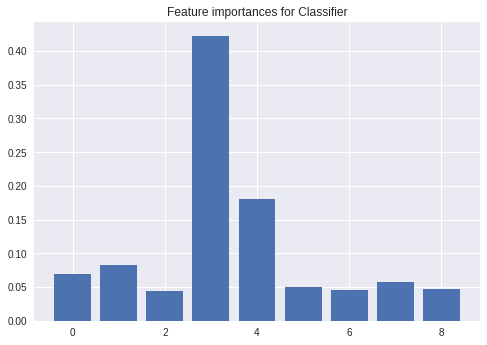

In [ ]:
plt.bar(range(len(rfmr.feature_importances_)),rfmr.feature_importances_)
plt.title("Feature importances for Classifier")

Predicting HFmrEF labels

In [ ]:
X_mr = pd.DataFrame(HFmrEF_data.drop(columns=['LVEF'])).to_numpy()
y_hfmref_rf = rfmr.predict(X_mr)
print("Number of HFpEF",len(np.where(y_hfmref_rf==1)[0]))
print("Number of HFrEF",len(np.where(y_hfmref_rf==0)[0]))

Number of HFpEF 42
Number of HFrEF 69


Training the final Classifier

In [ ]:
X_mrp = np.concatenate((X_pr_aug,X_mr))
Y_mrp_rf = np.concatenate((Y_pr_aug,y_hfmref_rf))
X_mrp = scaling_X(X_mrp,X_mrp)
X_mrp.shape

(655, 9)

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
cross_validation(rf_clf,X_mrp,Y_mrp_rf)

Average CV Accuracy Test 	91.78
Average CV ROC-AUC Score 	96.02
Average CV Recall Score 	87.06
Average CV Precision Score 	95.34
-----------------------------
Best Accuracy CV : 		98.46
Best ROC CV : 			99.86
Best Recall CV : 		96.77
Best Precision CV : 		100.00


Saving the Trained Classifier

In [ ]:
with open('HF_Classification_Model.pkl','wb') as f:
    pickle.dump(rf_clf,f)